# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [114]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)


Train data shape:  (49000, 3073)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [116]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print ('loss: %f' % loss)
print ('sanity check: %f' % (-np.log(0.1)))

loss: 2.358081
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

We expect the uniformly distributed weights to give a probability of 1 / 10 to each value. 


In [144]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

np.set_printoptions(suppress = True, precision = 4)
# As we did for the SVM, use numeric gradient check|ing as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.295368 analytic: -1.295368, relative error: 3.445188e-08
numerical: 1.164246 analytic: 1.164245, relative error: 5.173549e-08
numerical: -2.482920 analytic: -2.482920, relative error: 6.391239e-09
numerical: -4.330518 analytic: -4.330518, relative error: 9.097796e-09
numerical: 2.006010 analytic: 2.006009, relative error: 4.416305e-08
numerical: 2.969133 analytic: 2.969133, relative error: 1.482376e-08
numerical: -0.075247 analytic: -0.075247, relative error: 8.087280e-08
numerical: -5.725620 analytic: -5.725620, relative error: 3.753586e-09
numerical: 3.113291 analytic: 3.113291, relative error: 5.168530e-08
numerical: -0.651649 analytic: -0.651649, relative error: 4.769675e-08
numerical: -0.959306 analytic: -0.959307, relative error: 5.894886e-08
numerical: 2.674935 analytic: 2.674935, relative error: 1.774478e-08
numerical: -0.712781 analytic: -0.712781, relative error: 2.083919e-08
numerical: 0.042255 analytic: 0.042255, relative error: 3.006735e-07
numerical: 0.14366

In [145]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print ('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print ('Gradient difference: %f' % grad_difference)

naive loss: 2.358081e+00 computed in 0.146774s
vectorized loss: 2.358081e+00 computed in 0.011803s
Loss difference: 0.000000
Gradient difference: 0.000000


In [172]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
#We found that the learning rate that worked best was -6, ~2 and ~5
learning_rates = 10**np.random.uniform(-5.8, -5.15, size = 7)
#regularization, I have no idea still
regularization_strengths = 10**np.random.uniform(1, 3, size = 8)
print(learning_rates)
print(regularization_strengths)

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for rs in regularization_strengths:
    for lr in learning_rates:
        print("Current:\tlr:{}\trs:{}".format(lr, rs))
        softmax = Softmax()
        loss_hist, grad_hist = softmax.train(X_train, y_train, learning_rate = lr, reg = rs, verbose = False, num_iters = 500)
        y_pred_train = softmax.predict(X_train)
        y_pred_val = softmax.predict(X_val)
        train_acc = np.mean(y_pred_train == y_train)
        val_acc = np.mean(y_pred_val == y_val)
        results[(lr, rs)] = (train_acc, val_acc)
        print((train_acc, val_acc))
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax
            
        #grad_hist
        #plt.plot(loss_hist)
        #plt.show()
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

[0. 0. 0. 0. 0. 0. 0.]
[665.7933  66.3487  47.3831 646.2849  83.5675  16.6692  19.3549  50.9453]
Current:	lr:2.1333116170721537e-06	rs:665.7932570648866
(0.36448979591836733, 0.368)
Current:	lr:2.1333116170721537e-06	rs:66.34868613111574
(0.3270612244897959, 0.316)
Current:	lr:2.1333116170721537e-06	rs:47.38308271003929
(0.33338775510204083, 0.33)
Current:	lr:2.1333116170721537e-06	rs:646.2848552288151
(0.3630204081632653, 0.357)
Current:	lr:2.1333116170721537e-06	rs:83.56747434070547
(0.335734693877551, 0.356)
Current:	lr:2.1333116170721537e-06	rs:16.669154354882807
(0.3283877551020408, 0.324)
Current:	lr:2.1333116170721537e-06	rs:19.354900560200143
(0.33555102040816326, 0.337)
Current:	lr:2.1333116170721537e-06	rs:50.945268303803736
(0.3354285714285714, 0.32)
Current:	lr:4.471014718497708e-06	rs:665.7932570648866
(0.3713469387755102, 0.366)
Current:	lr:4.471014718497708e-06	rs:66.34868613111574
(0.3630816326530612, 0.372)
Current:	lr:4.471014718497708e-06	rs:47.38308271003929
(0.3586

In [167]:
"""
lr 6.787795e-06 reg 3.732693e+02
lr 4.474358e-06 reg 6.462849e+02
"""

'\nlr 2.725965e-06 reg 8.818019e+02\n'

In [179]:
lr = 2.725965e-06
rs = 8.818019e+02
#this one words best!
lr_ = 4.474358e-06
rs_ = 6.462849e+02

best_softmax = Softmax()
loss_hist = best_softmax.train(X_train, y_train, learning_rate = lr_, reg = rs_, num_iters = 1500, verbose = True)

iteration 0 / 1000: loss 14.805120
iteration 100 / 1000: loss 7.552092
iteration 200 / 1000: loss 4.667063
iteration 300 / 1000: loss 3.424812
iteration 400 / 1000: loss 2.872811
iteration 500 / 1000: loss 2.323888
iteration 600 / 1000: loss 2.016321
iteration 700 / 1000: loss 1.976955
iteration 800 / 1000: loss 1.849183
iteration 900 / 1000: loss 1.935443


In [180]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.396000


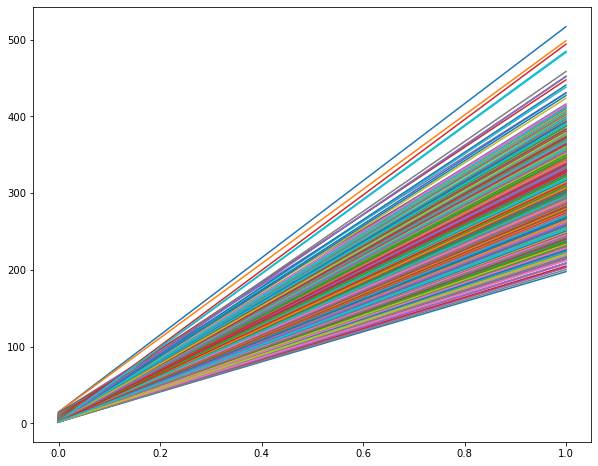

In [181]:
plt.plot(loss_hist)
plt.show()

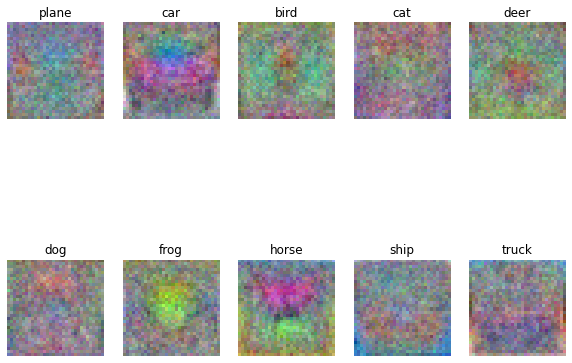

In [182]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

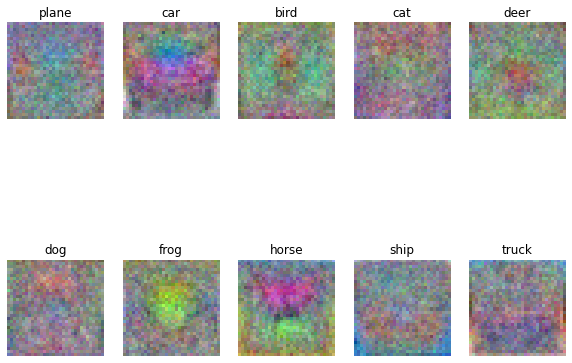

In [183]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
w = best_softmax.W[:-1, :]
min_w = np.min(w)
max_w = np.max(w)

for i, im in enumerate(w.T):
    image = im.reshape(32, 32, 3)
    image = 255.0 * (image - min_w) / (max_w - min_w)
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.axis("off")
    plt.title(classes[i])